# COMP90051 Project 2

**Copyright statement:** This notebook is copyright University of Melbourne. 
It is licensed for the sole purpose of your assessment in COMP90051. 
You are not permitted to share or publish derived versions of this notebook, other than with COMP90051 staff for assessment.

***

The code block below imports the namespaces/functions/classes you may use in the project. 
Additional imports are not permitted.

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod

# Type annotations
from numpy import ndarray
from numpy.random import Generator
from typing import List, Deque, Optional, Tuple

from sklearn.cluster import KMeans                   # for Task 3
from sklearn.linear_model import LogisticRegression  # for Task 4
from collections import deque                        # for Task 5
from scipy.stats import multivariate_normal          # for Task 5
import matplotlib.pyplot as plt                      # for Task 6

The base `MAB` class below defines a common interface for a contextual multi-armed bandit. 
Your bandit implementations in Tasks 1-4 should inherit from this class.

In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
        
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, rng: Optional[Generator] = None) -> None:
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        self.rng = np.random.default_rng(rng)
        
    @abstractmethod
    def play(self, context: ndarray) -> int:
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        
    @abstractmethod
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None) -> None:
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None.
            
        reward : float, optional
            Reward received from the arm. If None, the reward is missing.
        """
        if arm >= self.n_arms or arm < 0:
            raise ValueError("`arm` must be in the range "
                             "[0, {}]".format(self.n_arms - 1))

The function below implements off-policy evaluation as described in Appendix A of the project spec. 
You should use it—along with the provided dataset—to evaluate the bandits in Tasks 1-4.

In [3]:
def offline_eval(mab: MAB, arms: ndarray, rewards: ndarray, contexts: ndarray, 
                 n_rounds: Optional[int] = None) -> ndarray:
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : int ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float ndarray, shape (n_events,)
        Array containing the history of rewards. If a reward is missing, it 
        should be represented by `np.nan`.
    
    contexts : float ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, optional
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    matching_rewards : ndarray
        Rewards of matched events.
    
    matching_ids : ndarray
        Indices of matched events.
    """
    # Check types
    if not isinstance(mab, MAB):
        raise TypeError("`mab` must be an instance of MAB")
    arms = np.asarray(arms)
    rewards = np.asarray(rewards)
    contexts = np.asarray(contexts)
    if n_rounds is not None and n_rounds < 0:
        raise ValueError("`n_rounds` must be non-negative")
    
    # Check array dimensions
    if arms.ndim != 1:
        raise ValueError("`arms` must be a 1D array")
    if rewards.ndim != 1:
        raise ValueError("`rewards` must be a 1D array")
    if contexts.ndim != 3:
        raise ValueError("`contexts` must be a 3D array")
    if not (arms.shape[0] == rewards.shape[0] == contexts.shape[0]):
        raise ValueError("first dimension of input arrays are inconsistent")
    if contexts.shape[1] != mab.n_arms:
        raise ValueError("`contexts` has inconsistent second dimension")
    if arms.max() >= mab.n_arms or arms.min() < 0:
        raise ValueError("`arms` contains ids that are out-of-range")
    
    matched_ctr = 0
    matched_ids = list()
    for i in range(arms.size):
        if matched_ctr >= n_rounds:
            break
        arm_id = mab.play(contexts[i])
        if arm_id == arms[i]:
            reward = None if np.isnan(rewards[i]) else rewards[i]
            mab.update(arm_id, contexts[i], reward)
            matched_ctr += 1
            matched_ids.append(i)
    
    matched_ids = np.array(matched_ids)
    return rewards[matched_ids], matched_ids

Please define any static functions/variables (used across multiple tasks) in the code block below.

In [4]:
rng = np.random.default_rng(90051)  # Random generator used throughout

# Define additional static functions/variables here, if required
def tie_break(mab: MAB, top_arms: ndarray):
    """Randomly choose a top arm from an array of equal top arms
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to use the random generator from.
    
    top_arms : int ndarray 
        Non-empty array containing the pulled arms sharing the highest reward, 
        represented as integer indices in the set {0, ..., mab.n_arms}.
    
    Returns
    -------
    best_arm : int
        The randomly selected arm from `top_arms`.
    """
    # Input error handling
    if len(top_arms) == 0: raise ValueError("`top_arms` must not be empty")
    index = mab.rng.integers(top_arms.shape[0])
    return top_arms[index]

def plot_round(round_rewards: list, ax, 
               title: str = '', xlabel: str = 'x', ylabel: str = 'y',
               custom_x: Optional[list] = None):
    '''Plotting the cummulative rewards through each round on an `axes` object
    
    Parameters
    ----------
    round_rewards : list
        Non-empty list of rewards through each round.
    
    ax : instance of matplotlib.axes.Axes
        Axes that is going to be used for plotting on.

    title: str
        Plot title.

    xlabel: str
        Name for variables across x-axis.

    ylabel: str
        Name for variables across y-axis.

    custom_x: list, optional
        Cutomized data with equal length to `round_rewards` to set on x axis.
    '''
    # Input error handling
    if len(round_rewards) == 0:
        raise ValueError("`round_rewards` must not be empty")
    # Temporary workaround as importing axes object is not allowed
    if not all([callable(f) for f in [ax.plot, ax.set_title,
                                      ax.set_xlabel, ax.set_ylabel]]):
        raise ValueError("`axes` must be a matplotlib.axes.Axes object")
    if custom_x is not None and len(round_rewards) != len(custom_x):
        raise ValueError("`round_rewards`, `custom_x` must have same length")

    T = np.arange(0, len(round_rewards)) + 1
    cum_reward = np.cumsum(round_rewards) / T
    x = T if custom_x is None else custom_x
    ax.plot(x,cum_reward)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def multiple_grid_search(func, params: list, verbose: bool = True):
    '''Conduct grid search for a function given a list of parameters to try
    
    Parameters
    ----------
    func : callable
        Function to run grid search from.
    
    params : list(list)
        Non-empty list of list, containing the parameter lists to be tried.

    verbose : bool
        True if best result is to be printed.
    
    Returns
    -------
    param_sets : ndarray
        The array of possible combinations that is run on.

    mean_rw_list: list
        List of resultant mean rewards for each run.

    rw_list: list
        List of rewards received through each round for each run.
    '''
    # Input error handling
    if not callable(func): raise ValueError("`func` is not a callable function")
    if len(params) == 0: raise ValueError("`params` must be non-empty")
    if any([len(p)==0 for p in params]):
        raise ValueError("All elements of `params` must be non-empty")

    mean_rw_list = []
    rw_list = []
    # Getting a ndarray of all possible combinations
    param_sets = np.array(np.meshgrid(*params)).T.reshape(-1,len(params))
    # Invalid combinations that returned None
    invalid_param_index = []
    # Iterating through each combination
    for i,ps in enumerate(param_sets):
        rw, mean_rw = func(ps)
        if mean_rw is None:
            invalid_param_index.append(i)
        else:
            mean_rw_list.append(mean_rw)
            rw_list.append(rw)
    # Filter out invalid combinations
    param_sets = param_sets[[i for i in range(param_sets.shape[0]) 
                             if i not in invalid_param_index]]
    # Get the best result
    index_max = np.argmax(mean_rw_list)
    if verbose:
        print(f'\rFinished. Best result: {mean_rw_list[index_max]} '
              f'at params = {param_sets[index_max]}')
    return param_sets, mean_rw_list, rw_list

## Task 1: Implement LinUCB

In [5]:
class LinUCB(MAB):
    """LinUCB

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, alpha: float, 
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms, rng)
        # Input error handling
        if not alpha > 0.0 :
            raise ValueError("`alpha` must be positive")
        if not np.isreal(alpha):
            raise ValueError("`alpha` must be real")
        if not n_dims > 0:
            raise ValueError("`n_dims` must be positive")

        # Initiating parameters
        self.n_dims = n_dims
        self.alpha = alpha
        
        # Initiating inverse covariance matrices `Aa`, response vectors `ba`
        self.Aa = [np.identity(n_dims) for i in range(n_arms)]
        self.ba = [np.zeros(n_dims) for i in range(n_arms)]
        
    def play(self, context: ndarray) -> int:
        super().play(context)
        # Input error handling
        if context.ndim != 2:
            raise ValueError("`context` must be a 2D array")
        if context.shape[0] != self.n_arms:
            raise ValueError("`context` is inconsistent with `n_arms`")
        if context.shape[1] != self.n_dims:
            raise ValueError("`context` is inconsistent with `n_dims`")

        # Update the posterior distribution for each arm    
        p = []
        for arm in range(self.n_arms):
            # Retrieving mean (`theta`) and variance (`var`)
            theta = np.linalg.solve(self.Aa[arm],self.ba[arm])
            var = context[arm].T @ np.linalg.inv(self.Aa[arm]) @ context[arm]
            # Appending the distribution to the posterior list
            p.append(theta.T @ context[arm] + self.alpha*np.sqrt(var))

        # Get all the arms with highest probability, and tie break randomly
        top_arms = np.argwhere(p==np.max(p)).flatten()
        best_arm = tie_break(self, top_arms)
        return best_arm
    
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None) -> None:
        super().update(arm, context, reward)
        # Input error handling
        if arm >= self.n_arms or arm < 0:
            raise ValueError("`arm` id is out-of-range")
        if context.ndim != 2:
            raise ValueError("`context` must be a 2D array")
        if context.shape[0] != self.n_arms:
            raise ValueError("`context` is inconsistent with `n_arms`")
        if context.shape[1] != self.n_dims:
            raise ValueError("`context` is inconsistent with `n_dims`")
        
        # No update if reward is missing
        if reward is None: return

        # Reshaping context for consistent matrix multiplication
        xt = context[arm].reshape(-1,1)
        # Updating Aa and ba
        self.Aa[arm] = self.Aa[arm] + xt @ xt.T
        self.ba[arm] = self.ba[arm] + reward * context[arm]

In [6]:
# Load dataset here
data = np.loadtxt('dataset.txt')

# Extract the data
arms = data[:,0].astype(int)
rewards = data[:,1].astype(int)
contexts = data[:,3:].reshape(-1,10,10)

In [7]:
mab = LinUCB(10, 10, 1.0, rng)
LinUCB_rewards, _ = offline_eval(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(LinUCB_rewards))

LinUCB average reward 0.53


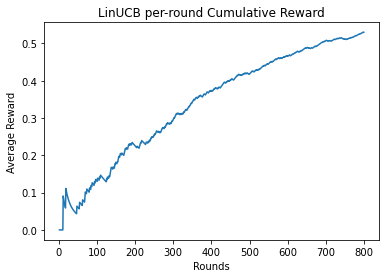

Executing Level 1 Grid Search:
Finished. Best result: 0.70875 at params = [0.1]
Executing Level 2 Grid Search:
Finished. Best result: 0.73125 at params = [0.02]


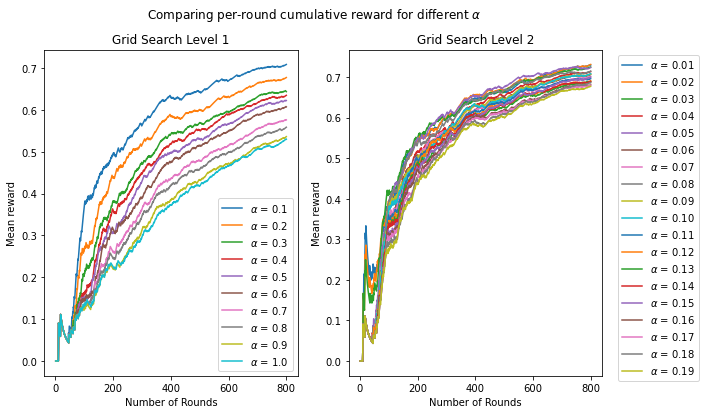

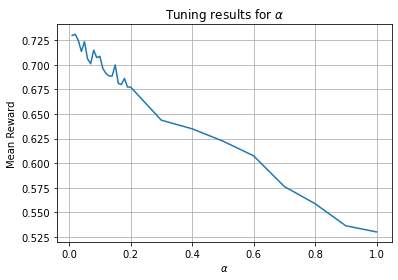

BEST MEAN REWARDS: 0.73125 at alpha = 0.02


In [8]:
# Use additional cells here for experimentation
def tuning_task_1(params: list):
    '''Tuning function for Task 1, to be put in `multiple_grid_search()` only: 
       Do offline evaluation for LinUCB and get mean rewards

    Parameters
    ----------
    params : list
        Single-element list of `[alpha]` values to be used for this task.

    Returns
    -------
    mean_rewards : float
        The mean reward for the input set of parameters.
    '''
    # Input error handling
    if len(params) != 1: raise ValueError("`params` must have length of 1")
    
    mab = LinUCB(10, 10, params[0], rng)
    LinUCB_rewards, _ = offline_eval(mab, arms, rewards, contexts, 800)
    mean_rewards = np.mean(LinUCB_rewards)
    print(f'\rLinUCB mean reward at alpha = {params[0]:.2f}: {mean_rewards}',
          end='')
    return LinUCB_rewards, mean_rewards

# Task 1b: Plotting reward by round
_, ax = plt.subplots()
plot_round(LinUCB_rewards, ax,
           'LinUCB per-round Cumulative Reward', 'Rounds', 'Average Reward')
plt.show()

# Task 1c: Grid Search
# Strategy: 2 search levels, described below

# Level 1: Do Grid Search of step 0.1 for alpha = [0.1,1.0]
step = 0.1
alpha_vals = np.arange(0.1, 1.0 + step, step)
print('Executing Level 1 Grid Search:')
p1,m1,r1 = multiple_grid_search(tuning_task_1, [alpha_vals])

# Level 2: Take level 1 best parameter as center, do 2nd Grid Search
# of step 0.01 for alpha = [center - 0.09, center + 0.09]
max_p = p1[np.argmax(m1)][0]
step_2 = 0.01
alpha_vals_iter_2 = np.arange(max_p-step_2*9, max_p+step_2*10, step_2)
print('Executing Level 2 Grid Search:')
p2,m2,r2 = multiple_grid_search(tuning_task_1, [alpha_vals_iter_2])

# Sort to get the parameter with best result
p = np.append(p1,p2)
m = np.append(m1,m2)
index_sorted = np.argsort(p)
p_sorted = p[index_sorted]
m_sorted = m[index_sorted]

# Plot comparison of cummulative rounds
_,ax2 = plt.subplots(1,2,figsize=(10,6))

for i in range(len(m1)):
    plot_round(r1[i], ax2[0], xlabel='Number of Rounds', ylabel='Mean reward')
ax2[0].legend([fr'$\alpha$ = {p[0]:.1f}' for p in p1])
ax2[0].set_title('Grid Search Level 1')

for i in range(len(m2)):
    plot_round(r2[i], ax2[1], xlabel='Number of Rounds', ylabel='Mean reward')
ax2[1].legend([fr'$\alpha$ = {p[0]:.2f}' for p in p2], bbox_to_anchor=(1.4,1))
ax2[1].set_title('Grid Search Level 2')

plt.suptitle(r'Comparing per-round cumulative reward for different $\alpha$')
plt.show()

# Plot the process out
plt.plot(p_sorted,m_sorted)
plt.grid(True)
plt.title(r'Tuning results for $\alpha$')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Reward')
plt.show()

index_max = np.argmax(m)
print(f'BEST MEAN REWARDS: {m[index_max]} at alpha = {p[index_max]:.2f}')

## Task 2: Implement MLinUCB

In [9]:
class MLinUCB(MAB):
    """MLinUCB

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    
    N : int
        Number of clusters
        
    m : int
        Number of closest clusters to use when imputing the reward.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, alpha: float, N: int, m: int, 
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms, rng)
        # Input error handling
        if not alpha > 0.0 :
            raise ValueError("`alpha` must be positive")
        if not np.isreal(alpha):
            raise ValueError("`alpha` must be real")
        if not n_dims > 0:
            raise ValueError("`n_dims` must be positive")
        if not N > 0:
            raise ValueError("`N` must be positive")
        if not m > 0:
            raise ValueError("`m` must be positive")
        # Legacy random state to use in KMeans random_state
        self.rnd_state = np.random.RandomState(self.rng.bit_generator)

        # Initialising parameters
        self.n_dims = n_dims
        self.alpha = alpha
        self.N = N
        self.m = m

        # Initialising inverse covariance matrices `Ak`, response vectors `bk`
        self.Ak = [np.identity(n_dims) for i in range(n_arms)]
        self.bk = [np.zeros(n_dims) for i in range(n_arms)]

        # Initialising histories and variable for clustering model
        self.context_history = []
        self.reward_history = []
        self.clusterer = None
    
    def play(self, context: ndarray) -> int:
        super().play(context)
        # Input error handling
        if context.ndim != 2:
            raise ValueError("`context` must be a 2D array")
        if context.shape[0] != self.n_arms:
            raise ValueError("`context` is inconsistent with `n_arms`")
        if context.shape[1] != self.n_dims:
            raise ValueError("`context` is inconsistent with `n_dims`")
    
        s = len(self.context_history)

        # Play as usual, but cluster the past contexts before that    
        self.clusterer = KMeans(min(self.N,s), random_state = self.rnd_state)
        p = []
        for arm in range(self.n_arms):
            # Retrieving mean (`theta`) and variance (`var`)
            theta = np.linalg.solve(self.Ak[arm],self.bk[arm])
            var = context[arm].T @ np.linalg.inv(self.Ak[arm]) @ context[arm]
            # Appending the distribution to the posterior list
            p.append(theta.T @ context[arm] + self.alpha*np.sqrt(var))
        # Get all the arms with highest probability, and tie break randomly
        top_arms = np.argwhere(p==np.max(p)).flatten()
        best_arm = tie_break(self, top_arms)
        return best_arm
    
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None) -> None:
        super().update(arm, context, reward)
        # Input error handling
        if arm >= self.n_arms or arm < 0:
            raise ValueError("`arm` id is out-of-range")
        if context.ndim != 2:
            raise ValueError("`context` must be a 2D array")
        if context.shape[0] != self.n_arms:
            raise ValueError("`context` is inconsistent with `n_arms`")
        if context.shape[1] != self.n_dims:
            raise ValueError("`context` is inconsistent with `n_dims`")
            
        s = len(self.context_history)
        # Case of missing reward: imputation
        if reward is None:
            # No update if nothing to cluster yet
            if not s>0: return
            
            self.clusterer.fit(self.context_history)
            m_cluster = min(self.m, s)
            # Get m closest clusters
            distances = [np.linalg.norm(context-centroid) 
                         for centroid in self.clusterer.cluster_centers_]
            closest_clusters = np.argsort(distances)[-m_cluster:]
            
            # Get weights from clusters, and combine to get imputed reward
            weighted_reward = 0.0
            weight_total = 0.0
            for d in closest_clusters:
                c_ids = np.argwhere(self.clusterer.labels_ == d).reshape(-1)
                r_j = np.mean(np.array(self.reward_history)[c_ids])
                weighted_reward += r_j/(0.1+distances[d])
                weight_total += 1/(0.1+distances[d])
            r = weighted_reward / weight_total
        else:
            r = reward
            
        # Update the available rewards to history
        self.context_history.append(context[arm])
        self.reward_history.append(r)

        # Reshaping context for consistent matrix multiplication
        xt = context[arm].reshape(-1,1)
        # Updating Aa and ba
        self.Ak[arm] = self.Ak[arm] + xt @ xt.T
        self.bk[arm] = self.bk[arm] + r * context[arm]

In [10]:
# Define rewards_missing here - the rewards array from above where missing values are represented as np.nan
rewards_missing = np.array([np.nan if data[i,2] else data[i,1] 
                                   for i in range(data.shape[0])])

In [11]:
mab = MLinUCB(10, 10, 1.0, 10, 3, rng)
MLinUCB_rewards, MLinUCB_ids = offline_eval(mab, arms, rewards_missing, contexts, 800)
print('MLinUCB average reward', np.mean(rewards[MLinUCB_ids]))

mab = LinUCB(10, 10, 1.0, rng)
LinUCB_rewards, LinUCB_ids = offline_eval(mab, arms, rewards_missing, contexts, 800)
print('LinUCB average reward', np.mean(rewards[LinUCB_ids]))

MLinUCB average reward 0.335
LinUCB average reward 0.37875


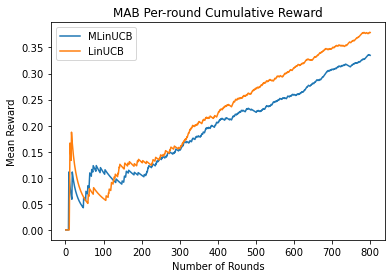

Executing Level 1 Grid Search:
Finished. Best result: 0.575 at params = [0.1 6.  6. ]
Executing Level 2 Grid Search:
Finished. Best result: 0.6075 at params = [0.08 5.   5.  ]


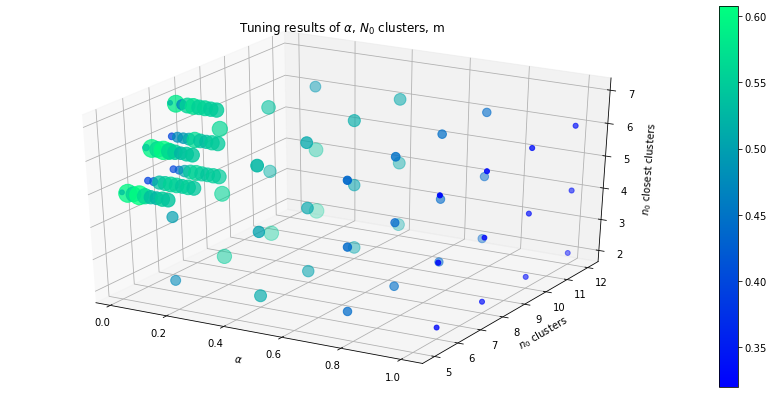

BEST MEAN REWARDS: 0.6075 at [alpha, n_clusters, m] = [0.08, 5, 5]


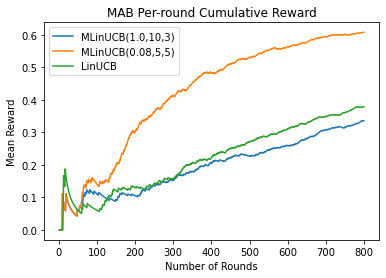

In [12]:
# Use additional cells here for experimentation
def tuning_task_2(params: list):
    '''Tuning function for Task 2, to be put in `multiple_grid_search()` only: 
       Do offline evaluation for MLinUCB and get mean rewards

    Parameters
    ----------
    params : list
        3-element list containing `[alpha,N,m]` values to be used for this task.

    Returns
    -------
    mean_rewards : float
        The mean reward for the input set of parameters.
    '''
    # Input error handling
    if len(params) != 3: raise ValueError("`params` must contain 3 parameters")
   
    # Invalid combination if m > N
    if params[2] > params[1]:
        return None, None
    mab = MLinUCB(10, 10, params[0], int(params[1]), int(params[2]), rng)
    _, MLinUCB_ids = offline_eval(mab, arms, rewards_missing, contexts, 800)
    mean_rewards = np.mean(rewards[MLinUCB_ids])
    print(f'\rLinUCB average reward at alpha={params[0]:.2f}, '
          f'N={int(params[1])}, m={int(params[2])}: {mean_rewards}', end='')
    return rewards[MLinUCB_ids], mean_rewards

# Task 2b: Plotting truth reward by round for comparison
_, ax = plt.subplots()
plot_round(rewards[MLinUCB_ids], ax)
plot_round(rewards[LinUCB_ids], ax,
           'MAB Per-round Cumulative Reward', 
           'Number of Rounds', 
           'Mean Reward')
plt.legend(['MLinUCB','LinUCB'])
plt.show()

# Task 2c: Grid Search
# Strategy: 2 search levels, described below

# Level 1: Do Grid Search near the default values, specifically :
# - alpha = [0.1,1.0] of step 0.1
# - number of clusters = [6,8,10,12]
# - m closest clusters = [2,4,6]
step = 0.3
alpha = np.arange(0.1, 1.0 + step, step)
N_vals = [6,8,10,12]
m_vals = [2,4,6]
print('Executing Level 1 Grid Search:')
p1,m1,_ = multiple_grid_search(tuning_task_2, [alpha, N_vals, m_vals])
# Plot will show that larger m has more consistent largest values
# Therefore, favor larger m, for more consistency between runs
max_index = np.argwhere(m1 == np.max(m1))[-1,0]
max_p = p1[max_index]

# Level 2: Take level 1 best parameter as center, do 2nd Grid Search for
# - alpha = [center alpha - 0.08, center alpha + 0.08] of step 0.02
# - number of clusters = [center n_clusters - 1, center n_clusters + 1]
# - m closest clusters = [center m - 1, center m + 1]
step_2 = 0.02
alpha_2 = np.arange(max_p[0]-step_2*4, max_p[0]+step_2*5, step_2)
N_vals_2 = np.arange(max_p[1]-1,max_p[1]+2)
m_vals_2 = np.arange(max_p[2]-1,max_p[2]+2)
print('Executing Level 2 Grid Search:')
p2,m2,r2 = multiple_grid_search(tuning_task_2, [alpha_2, N_vals_2, m_vals_2])

# Get the parameter with best result
p = np.append(p1,p2,axis=0)
m = np.append(m1,m2)

# Plotting out the process
fig2 = plt.figure(figsize=(15,7))
ax2 = plt.axes(projection='3d')
unit_size = 16000
plot = ax2.scatter(p[:,0], p[:,1], p[:,2],
                  # Show mean reward through color and size of points
                  c = m, s = [unit_size**m_reward for m_reward in m],
                  cmap = 'winter')
ax2.set_xlabel(r'$\alpha$')
ax2.set_ylabel(r'$n_0$ clusters')
ax2.set_zlabel(r'$n_0$ closest clusters')
ax2.set_title(r'Tuning results of $\alpha$, $N_0$ clusters, m')
fig2.colorbar(plot)
plt.show()

# Get the maximum result. Again, favor bigger m for more stability
index_max = np.argwhere(m2 == np.max(m2))[-1,0]
print(f'BEST MEAN REWARDS: {m2[index_max]} at [alpha, n_clusters, m] = '
    f'[{p2[index_max,0]:.2f}, {int(p2[index_max,1])}, {int(p2[index_max,2])}]')

# Plot comparing best tuned model vs. originals
_, ax3 = plt.subplots()
plot_round(rewards[MLinUCB_ids], ax3)
plot_round(r2[index_max], ax3)
plot_round(rewards[LinUCB_ids], ax3,
           'MAB Per-round Cumulative Reward', 
           'Number of Rounds', 
           'Mean Reward')
ax3.legend(['MLinUCB(1.0,10,3)',
            f'MLinUCB({p2[index_max,0]:.2f},'
            f'{int(p2[index_max,1])},{int(p2[index_max,2])})',
            'LinUCB'])
plt.show()


## Task 3: Implement SquareCB

In [13]:
class SquareCB(MAB):
    """SquareCB with a logistic regression oracle

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.
    
    gamma : float
        Learning rate parameter.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, gamma: float, 
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms, rng)
        # Input error handling
        if not gamma > 0.0 :
            raise ValueError("`gamma` must be positive")
        if not np.isreal(gamma):
            raise ValueError("`gamma` must be real")
        if not n_dims > 0:
            raise ValueError("`n_dims` must be positive")

        # Initialising parameters
        self.n_dims = n_dims
        self.gamma = gamma

        # Initialising oracles and their training data (1 oracle/arm)
        self.oracle = [LogisticRegression() for i in range(n_arms)]
        self.train_x = [[] for i in range(n_arms)]
        self.train_y = [[] for i in range(n_arms)]
    
    def play(self, context: ndarray) -> int:
        super().play(context)
        # Input error handling
        if context.ndim != 2:
            raise ValueError("`context` must be a 2D array")
        if context.shape[0] != self.n_arms:
            raise ValueError("`context` is inconsistent with `n_arms`")
        if context.shape[1] != self.n_dims:
            raise ValueError("`context` is inconsistent with `n_dims`")

        # Oracle handing variable: List of arms with incomplete oracles
        incomplete_arms = [arm for arm in range(self.n_arms) 
                           if len(set(self.train_y[arm])) < 2]

        # Case of remaining insufficient oracles: randomly select one of them
        if incomplete_arms:
            return self.rng.choice(incomplete_arms)

        # Get prediction for each arm
        preds = np.array([])
        for arm in range(self.n_arms):
            # Retrieving oracle's prediction
            xta = context.flatten()
            pred = self.oracle[arm].predict([xta])
            # Appending the prediction's probability to list
            preds = np.append(preds,pred)

        # Get all the arms with highest probability, and tie break randomly
        lowest_arms = np.argwhere(preds==np.min(preds)).flatten()
        l_arm = tie_break(self, lowest_arms)

        probs = [1/(self.n_arms + self.gamma * (preds[a]-preds[l_arm]))
                 for a in range(self.n_arms) if a != l_arm]
        arm_prob = 1 - np.sum(probs)

        # Sampling
        probs.insert(l_arm, arm_prob)
        a_t = self.rng.choice(self.n_arms, p=probs)
        return a_t
    
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None) -> None:
        super().update(arm, context, reward)
        # Input error handling
        if arm >= self.n_arms or arm < 0:
            raise ValueError("`arm` id is out-of-range")
        if context.ndim != 2:
            raise ValueError("`context` must be a 2D array")
        if context.shape[0] != self.n_arms:
            raise ValueError("`context` is inconsistent with `n_arms`")
        if context.shape[1] != self.n_dims:
            raise ValueError("`context` is inconsistent with `n_dims`")

        # Update the oracle
        xta = context.flatten()
        self.train_x[arm].append(xta)
        self.train_y[arm].append(-reward)
        # Only fit if there is enough training class
        if not len(set(self.train_y[arm])) < 2: 
            self.oracle[arm].fit(self.train_x[arm],self.train_y[arm])

        

In [14]:
mab = SquareCB(10, 10, 18.0, rng)
SquareCB_rewards, _ = offline_eval(mab, arms, rewards, contexts, 800)
print('SquareCB average reward', np.mean(SquareCB_rewards))

SquareCB average reward 0.5625


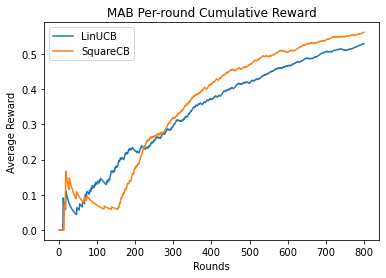

Executing Level 1 Grid Search:


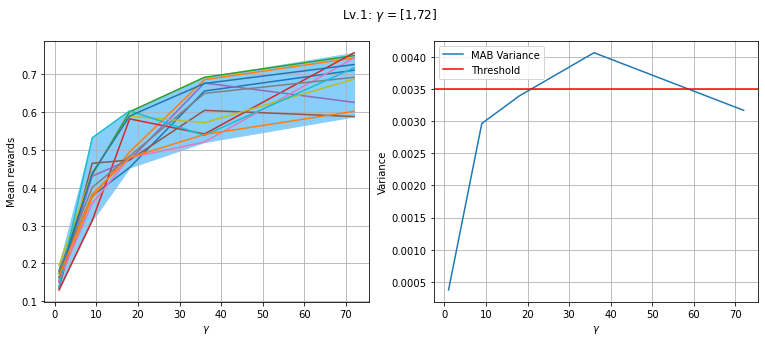

RUN 1 - BEST STABLE MEAN REWARDS: 0.52562 at gamma = 18.0
Executing Level 2 Grid Search:


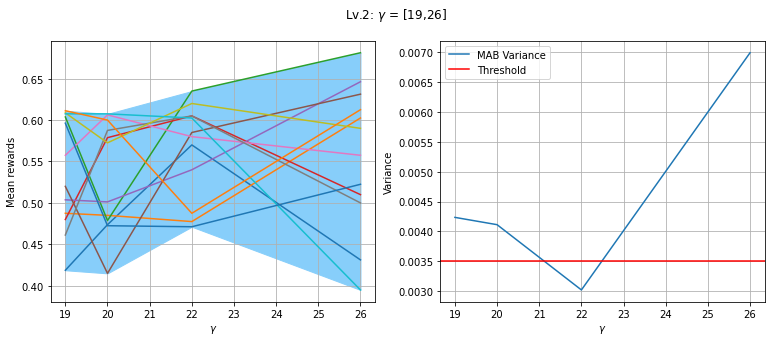

RUN 2 - No value satisfy the threshold
BEST STABLE MEAN REWARD: 0.52562 at gamma = 18.0


In [15]:
# Use additional cells here for experimentation
def tuning_task_3(params: list):
    '''Tuning function for Task 3, to be put in `multiple_grid_search()` only: 
       Do offline evaluation for SquareCB and get mean rewards

    Parameters
    ----------
    params : list
        Singe-element list containing `[gamma]` values to be used for this task.

    Returns
    -------
    mean_rewards : float
        The mean reward for the input set of parameters.
    '''
    # Input error handling
    if len(params) != 1: raise ValueError("`params` must contain 1 parameter")
   
    mab = SquareCB(10, 10, params[0], rng)
    SquareCB_rewards, _ = offline_eval(mab, arms, rewards, contexts, 800)
    mean_rewards = np.mean(SquareCB_rewards)
    print(f'\rSquareCB mean reward at gamma = {params[0]:.2f}: {mean_rewards}',
          end='')
    return SquareCB_rewards, mean_rewards

def grid_search_task_3c(gamma: list, level: int, 
                        n_iterations: int, threshold: float):
    '''Grid Search function for Task 3c:
       Do grid search repeatedly on a set of values, and check their span to
       see if the value returned stable results. Method explanation is
       available at Task 3c Section, where this function will be used.

    Parameters
    ----------
    gamma : list
        List containing gamma values to be used for this task.
    
    level: int
        The number of level that the grid search is on.

    n_iterations: int
        The number of runs to repeat on each value.

    threshold: float
        The maximum variance to consider the generated outputs as stable.

    Returns
    -------
    m_best : float
        The best stable mean rewards.

    p_best: float
        The parameter that returned the best stable mean rewards.

    m: ndarray
        Mean rewards for each run.
    '''
    # Input error handling
    if len(gamma) == 0: raise ValueError("`gamma` must be non-empty")
    if not level > 0: raise ValueError("`level` must be positive")
    if not n_iterations > 0: raise ValueError("`n_iterations` must be positive")
    if not threshold > 0: raise ValueError("`threshold` must be positive")

    print(f'Executing Level {level} Grid Search:')
    _,ax = plt.subplots(1,2,figsize=(12.8,4.8))
    m = [[] for i in range(n_iterations)]
    
    # Repeated runs of Grid Search, also plot these runs out
    for i in range(n_iterations):
        p,m[i],_ = multiple_grid_search(tuning_task_3, 
                                        [gamma], verbose = False)
        print(f'\r Run {i+1} finished.', end='')
        ax[0].plot(p,m[i])
    print('\r', end='')
    m_mean = np.mean(m,axis=0)
    m_max = np.max(m,axis=0)
    m_min = np.min(m,axis=0)
    m_var = np.var(m, axis=0)

    # Plot out coverage zones
    ax[0].fill_between(p.flatten(), m_max, m_min,
                    color='lightskyblue')
    ax[0].set_xlabel(r'$\gamma$')
    ax[0].set_ylabel('Mean rewards')
    ax[0].grid(True)

    # Plot variance
    ax[1].plot(p,m_var)
    ax[1].axhline(y = threshold, color = 'r')
    ax[1].set_xlabel(r'$\gamma$')
    ax[1].set_ylabel('Variance')
    ax[1].legend(['MAB Variance','Threshold'])
    ax[1].grid(True)

    plt.suptitle(fr'Lv.{level}: $\gamma$ = [{min(gamma):.0f},{max(gamma):.0f}]')
    plt.show()

    # Stop taking values where uncertainty (variance > threshold) starts
    stable_index = np.argwhere(m_var < threshold)
    for i in range(stable_index.size-1):
        if (stable_index[i+1]-stable_index[i])[0] != 1:
            stable_index = stable_index[:i+1]
            break
    # If no satisfied index or unstable start, return informing negative value
    if not stable_index.size or stable_index[0][0]:
        print(f'RUN {level} - No value satisfy the threshold')
        return -1, -1, m
    max_index = np.argmax(m_max[stable_index])
    
    # Get the best stable gamma
    p_best = p[stable_index][max_index][0,0]
    m_best = m_mean[stable_index][max_index][0]
    print(f'RUN {level} - BEST STABLE MEAN REWARDS: {m_best:.5f} '
          f'at gamma = {p_best:.1f}')
    return m_best, p_best, m

# Task 3b: Plotting reward by round
_, ax = plt.subplots()

# Plotting LinUCB
mab = LinUCB(10, 10, 1.0, rng)
LinUCB_rewards, _ = offline_eval(mab, arms, rewards, contexts, 800)
plot_round(LinUCB_rewards, ax)

# Plotting SquareCB
plot_round(SquareCB_rewards, ax,
           'MAB Per-round Cumulative Reward', 'Rounds', 'Average Reward')
ax.legend(['LinUCB', 'SquareCB'])
plt.show()

# Task 3c: Grid Search
# - OBSERVATION: As gamma (exploitation) increases, average mean reward will
#    increase, but variance will also increase. The best parameter should keep
#    a reasonable level of variance. 
# - ASSUMING normal distribution, variance of s**2 (st.dev = s) ensures 68%
#    of results is within +-s accuracy (95% for 2s, and 99.5% for 3s)
# - STRATEGY: 2 search levels, described below

# Runs for each parameter. Every run takes around 100s
n_iterations = 12
# Max variance of rewards to be considered stable. Variance of 35e-4 
# (std = 5.9e-2) ensures 68% of result is within mean +- 5.9e-2 accuracy
threshold = 35e-4 

# Level 1: Do Grid Search of 9 x logspace base 2 steps: gamma = [1,9,18,36,72]
step_1 = 9*np.logspace(0,3,4,base=2)
gamma = np.append(1,step_1)
m1_best, p1_best, m1 = grid_search_task_3c(gamma, 1, n_iterations, threshold)

# Level 2: Take level 1 best parameter as start, do 2nd Grid Search
# of logspace base 2 steps for alpha = [lv1_best+1, lv1_best+8]
step_2 = np.logspace(0,3,4,base=2)
gamma_2 = [p1_best+i for i in step_2]
m2_best, p2_best, m2 = grid_search_task_3c(gamma_2, 2, n_iterations, threshold)

print(f'BEST STABLE MEAN REWARD: '
      f'{m2_best if m2_best > m1_best else m1_best:.5f}'
      f' at gamma = {p2_best if m2_best > m1_best else p1_best}')